In [15]:
# DIR_PATH = "/cpt_training/app"

In [16]:
# cd {DIR_PATH}

In [17]:
# %pip install -U "setuptools<58" # setuptoolsのverが58以上だと、xfeatの依存パッケージml-metricsのinstallに失敗するため
# %pip install -q optuna xfeat japanize-matplotlib
# %pip install -q optuna

In [18]:
# import
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
# パラメータチューニングで必要なライブラリ
import optuna
from sklearn.metrics import mean_absolute_error

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'

In [21]:
BASE_PATH = './'

In [22]:
paths = glob(BASE_PATH + 'input/train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

# train_df, test_df, val_dfをくっつける
master_df = pd.concat([train_df, test_df])
master_df.sort_values('取引時点', inplace=True)
master_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_110/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/tmp/ipykernel_110/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [23]:
master_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

In [24]:
set(test_df['取引時点'])

{'2020年第１四半期', '2020年第２四半期'}

In [25]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [26]:
master_df.shape

(656817, 28)

In [27]:
master_df.head(20)

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,13342322,中古マンション等,NaN,13119,東京都,板橋区,相生町,志村三丁目,8,３ＬＤＫ,55,NaN,NaN,NaN,平成8年,ＲＣ,住宅,NaN,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2005年第３四半期,未改装,NaN,7.380211
1,27217286,中古マンション等,NaN,27118,大阪府,大阪市城東区,成育,野江,2,１Ｒ,10,NaN,NaN,NaN,平成3年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,80.0,300.0,2005年第３四半期,未改装,NaN,6.380211
2,13390266,中古マンション等,NaN,13122,東京都,葛飾区,亀有,亀有,4,３ＬＤＫ,50,NaN,NaN,NaN,昭和64年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,500.0,2005年第３四半期,未改装,NaN,7.176091
3,14171546,中古マンション等,NaN,14102,神奈川県,横浜市神奈川区,子安通,新子安,NaN,１Ｋ,15,NaN,NaN,NaN,昭和63年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005年第３四半期,未改装,NaN,6.763428
4,14206047,中古マンション等,NaN,14108,神奈川県,横浜市金沢区,六浦南,六浦,8,１ＬＤＫ,50,NaN,NaN,NaN,平成2年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種低層住居専用地域,50.0,100.0,2005年第３四半期,未改装,NaN,7.146128
5,14181283,中古マンション等,NaN,14104,神奈川県,横浜市中区,常盤町,関内,NaN,１Ｒ,25,NaN,NaN,NaN,昭和58年,ＳＲＣ,事務所,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005年第３四半期,改装済,NaN,6.919078
6,14238904,中古マンション等,NaN,14113,神奈川県,横浜市緑区,長津田,長津田,8,３ＬＤＫ,70,NaN,NaN,NaN,平成14年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,150.0,2005年第３四半期,未改装,NaN,7.602060
7,14210066,中古マンション等,NaN,14109,神奈川県,横浜市港北区,新横浜,新横浜,NaN,１ＬＤＫ,40,NaN,NaN,NaN,平成17年,ＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,800.0,2005年第３四半期,NaN,NaN,7.477121
8,13181527,中古マンション等,NaN,13108,東京都,江東区,福住,清澄白河,11,３ＤＫ,55,NaN,NaN,NaN,昭和48年,鉄骨造,住宅,NaN,NaN,NaN,NaN,準工業地域,60.0,300.0,2005年第３四半期,未改装,NaN,7.079181
9,13198335,中古マンション等,NaN,13109,東京都,品川区,南大井,大森(東京),9,１Ｋ,20,NaN,NaN,NaN,平成17年,ＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,400.0,2005年第３四半期,改装済,NaN,7.278754


In [28]:
class Preprocessor:
    TARGET = TARGET
    group_col = group_col
    time_col = time_col

    def __init__(self, df):
        self.df = df.copy()
        self.agg_dfs = []
        self.labeling()

    @staticmethod
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(float(moyori))
        return moyori

    @staticmethod
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
        return area

    @staticmethod
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki

    @staticmethod
    def allocate(data):
        if pd.isna(data) or data == "":
            return 0
        else:
            if 'LDK' in data:
                return 1
            elif 'DK' in data:
                return 2
            elif 'K' in data:
                return 3
            elif 'フリースペース' in data:
                return 4
            else:
                return 5

    @staticmethod
    def extract_room_count(s):
        if pd.isna(s) or s == '':
            return 0
        numbers = re.findall(r'\d+', s)
        return int(numbers[0]) if numbers else 0

    def name_to_number(self):
        """取引時点を数字に変更する関数"""
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(self.df['取引時点'].values)))):
            enc_dic[e] = i
        self.df['取引時点_enc'] = self.df['取引時点'].map(enc_dic)
        return self.df

    def remove_data(self):
        """全て同じ値になっていたり、すべてnullになっているものは削除する!"""
        rm_cols = [col for col in self.df.columns if self.df[col].nunique() <= 1]
        self.df.drop(columns=rm_cols, inplace=True)
        self.df.dropna(axis=1, how='all')

    def calc_mean_target(self):
        """各取引時点,都道府県での各都道府県のTARGETの平均値"""
        @staticmethod
        def calc_te(row):
            if row[self.time_col] in te_dic and row[self.group_col] in te_dic[row[self.time_col]]:
                try:
                    value = te_dic[row[self.time_col]-2][row[self.group_col]]
                except IndexError as e:
                    value = 0
                return value
            else:
                return 0
        te_dic = {}
        for i in set(self.df[self.time_col].values):
            tmp_df = self.df[self.df[self.time_col] < i]
            te_dic[i] = tmp_df.groupby(self.group_col)[TARGET].agg('mean').to_dict()
        # 最後にdfにapplyする
        self.df[self.group_col + '_te'] = self.df.apply(self.calc_te, axis=1)
        return self.df

    def get_agg_df(self):
        """group_valuesそれぞれのagg_methosを計算してくれるやつ"""
        agg_df, agg_cols = aggregation(self.df,
                            group_key=self.group_col,
                            group_values=['最寄駅：距離（分）', '容積率（％）'],
                            agg_methods=['count', 'mean', 'min', 'max'],
                            )
        return agg_df[agg_cols]

    def labeling(self):
        """データを切り取って渡してくれる"""
        self.df.sort_values('取引時点', inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.df.loc[self.df['取引時点'].str.contains('2019年第３四半期|2019年第４四半期', regex=True), 'label'] = 1
        self.df.loc[self.df['取引時点'].str.contains('2020年第１四半期|2020年第２四半期', regex=True), 'label'] = 2
        self.df.loc[self.df['label'].isnull(), 'label'] = 0
        # self.feat_cols = [col for col in self.df.columns if col not in rm_cols+[ID, TARGET]]
        # self.df.dropna(how='any', axis=0)

    @staticmethod
    def checkStringExistence(input='', word=''):
        if not isinstance(input, str):
            return 0
        
        if word in input:
            return 1
        else:
            return 0
        
    def dummy(self, dummy_column):
        df_dummies = pd.get_dummies(self.df[dummy_column], prefix=dummy_column, drop_first=True)
        self.df = pd.concat([self.df, df_dummies], axis=1)
        self.df.drop(columns=dummy_column, axis=1)

    def fit(self):
        self.remove_data()
        self.df['取引時点_何年前'] = self.df['取引時点'].apply(lambda x: 2020-int(x[:4]))
        self.name_to_number()
        # self.df.drop(columns=['取引時点'], axis=1, inplace=True)
        self.df['部屋数'] = self.df['間取り'].apply(self.extract_room_count)
        self.df['部屋タイプ'] = self.df['間取り'].apply(lambda x: self.allocate(x))
        self.df['建築年'] = self.df['建築年'].apply(lambda x: self.convert_wareki_to_seireki(x))
        self.df['面積（㎡）'] = self.df['面積（㎡）'].apply(lambda x: self.normalize_area(x))
        self.df['最寄駅：距離（分）'] = self.df['最寄駅：距離（分）'].apply(lambda x: self.normalize_moyori(x))
        self.df['心理的瑕疵の有無'] = self.df['取引の事情等'].apply(lambda input: self.checkStringExistence(input, '瑕疵有りの可能性')) # "瑕疵有りの可能性"を別のカラムに追加、次のコードで別の列から削除
        self.df['取引の事情等'].replace({'調停・競売等、瑕疵有りの可能性': '調停・競売等',
                                   '関係者間取引、瑕疵有りの可能性': '関係者間取引',
                                   '瑕疵有りの可能性': np.nan}, inplace=True)
        self.dummy('都市計画')

    def transform(self):
        num_df = SelectNumerical().fit_transform(self.df)
        encoder = Pipeline([
            SelectCategorical(),
            LabelEncoder(output_suffix=""),
            ])
        le_df = encoder.fit_transform(self.df)
        self.agg_dfs.append(self.get_agg_df())
        self.preprocessed_df = pd.concat([num_df,le_df]+self.agg_dfs, axis=1)
        return self.preprocessed_df

In [29]:
# master_dfを処理していく
processor = Preprocessor(master_df)
processor.fit()
preprocessed_df = processor.transform()



In [30]:
# データの割り振り
train_df = preprocessed_df.loc[preprocessed_df['label']==0, :]
train_x = train_df.drop(columns=['label', TARGET])
# train_x.dropna(how='any', axis=0)
train_y = train_df[TARGET]

# データの割り振り
val_df = preprocessed_df.loc[preprocessed_df['label']==1, :]
val_x = val_df.drop(columns=['label', TARGET])
# val_x.dropna(how='any', axis=0)
val_y = val_df[TARGET]

# データの割り振り
test_df = preprocessed_df.loc[preprocessed_df['label']==2, :]
test_x = test_df.drop(columns=['label', TARGET])
# test_x.dropna(how='any', axis=0)
test_y = test_df[TARGET]

In [31]:
train_df

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,label,取引時点_何年前,取引時点_enc,部屋数,部屋タイプ,心理的瑕疵の有無,都市計画_工業地域,都市計画_工業専用地域,都市計画_市街化区域及び市街化調整区域外の都市計画区域,都市計画_市街化調整区域,都市計画_準住居地域,都市計画_準工業地域,都市計画_準都市計画区域,都市計画_第１種中高層住居専用地域,都市計画_第１種低層住居専用地域,都市計画_第１種住居地域,都市計画_第２種中高層住居専用地域,都市計画_第２種低層住居専用地域,都市計画_第２種住居地域,都市計画_近隣商業地域,都市計画_都市計画区域外,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_count_容積率（％）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,agg_mean_容積率（％）_grpby_都道府県名,agg_min_最寄駅：距離（分）_grpby_都道府県名,agg_min_容積率（％）_grpby_都道府県名,agg_max_最寄駅：距離（分）_grpby_都道府県名,agg_max_容積率（％）_grpby_都道府県名
0,13342322,13119,8.0,55,1996.0,80.0,300.0,7.380211,0.0,15,0,3,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,0,0,0,0,0,0,-1,0,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
1,13114732,13103,5.0,55,1995.0,NaN,NaN,7.690196,0.0,15,0,2,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,1,1,1,1,1,0,-1,-1,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
2,13386156,13121,25.0,50,1995.0,60.0,200.0,6.944483,0.0,15,0,2,5,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,2,2,2,1,0,0,-1,1,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
3,13323693,13116,NaN,25,NaN,NaN,NaN,7.041393,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,3,3,-1,2,-1,0,-1,-1,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
4,13145614,13105,NaN,25,1973.0,80.0,500.0,6.857332,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,4,4,3,2,0,0,-1,2,0,-1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612438,40019126,40133,6.0,25,2010.0,80.0,400.0,7.146128,0.0,1,55,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,11,144,2298,1100,3,0,0,0,2,55,0,-1,29370,28724,12.282499,294.480226,0.0,50.0,120.0,1200.0
612439,13005603,13102,12.0,55,2009.0,80.0,500.0,7.724276,0.0,1,55,3,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,40,708,515,0,1,-1,0,2,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612440,13207671,13123,14.0,60,2007.0,60.0,300.0,7.518514,0.0,1,55,3,5,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0,47,1440,747,0,0,0,0,6,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612441,13300960,13219,4.0,80,1995.0,60.0,200.0,7.698970,0.0,1,55,4,5,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,297,4978,1763,7,0,0,0,1,55,1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0


モデル構築

In [32]:
train_set = lgb.Dataset(train_x, label=train_y)
val_set = lgb.Dataset(val_x, label=val_y)

In [33]:
def objective(trial):
  params = {
      "objective": "regression",
      "metric": "mae",
      "boosting_type": "rf",
      "verbosity": -1,
      "boost_from_average": "false",
      "random_seed": 42,
      "feature_pre_filter": False,
      "max_depth": trial.suggest_int('max_depth', 4, 8),
      "num_leaves": trial.suggest_int("num_leaves", 2, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
      "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
      }

  model = lgb.train(params, train_set, valid_sets=[val_set])

  pred_y = model.predict(val_x, num_iteration=model.best_iteration)
  mae = mean_absolute_error(val_y, pred_y)

  return mae

In [34]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-02-03 06:38:19,827] A new study created in memory with name: no-name-233cb179-2d80-4e6b-bcaa-99582b98d15c
[I 2024-02-03 06:38:21,287] Trial 0 finished with value: 0.20959320415546287 and parameters: {'max_depth': 6, 'num_leaves': 75, 'learning_rate': 0.07074510434715403, 'feature_fraction': 0.14371816710830343, 'bagging_fraction': 0.8402887919515375, 'min_child_samples': 23, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.20959320415546287.
[I 2024-02-03 06:38:22,989] Trial 1 finished with value: 0.15147983808014145 and parameters: {'max_depth': 7, 'num_leaves': 65, 'learning_rate': 0.018966060234924316, 'feature_fraction': 0.9818701132433435, 'bagging_fraction': 0.6633653928955703, 'min_child_samples': 19, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.15147983808014145.
[I 2024-02-03 06:38:24,926] Trial 2 finished with value: 0.14631407110049097 and parameters: {'max_depth': 8, 'num_leaves': 67, 'learning_rate': 0.036662537164646986, 'feature_fraction': 0.7398513

In [35]:
best_params = study.best_params
# 最適モデルで再度トレーニング
model = lgb.train(best_params, train_set, valid_sets=[val_set]) # early_stopping_roundsは使えなくなったそう。

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1997
[LightGBM] [Info] Number of data points in the train set: 612443, number of used features: 47
[LightGBM] [Info] Start training from score 7.214606


In [36]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

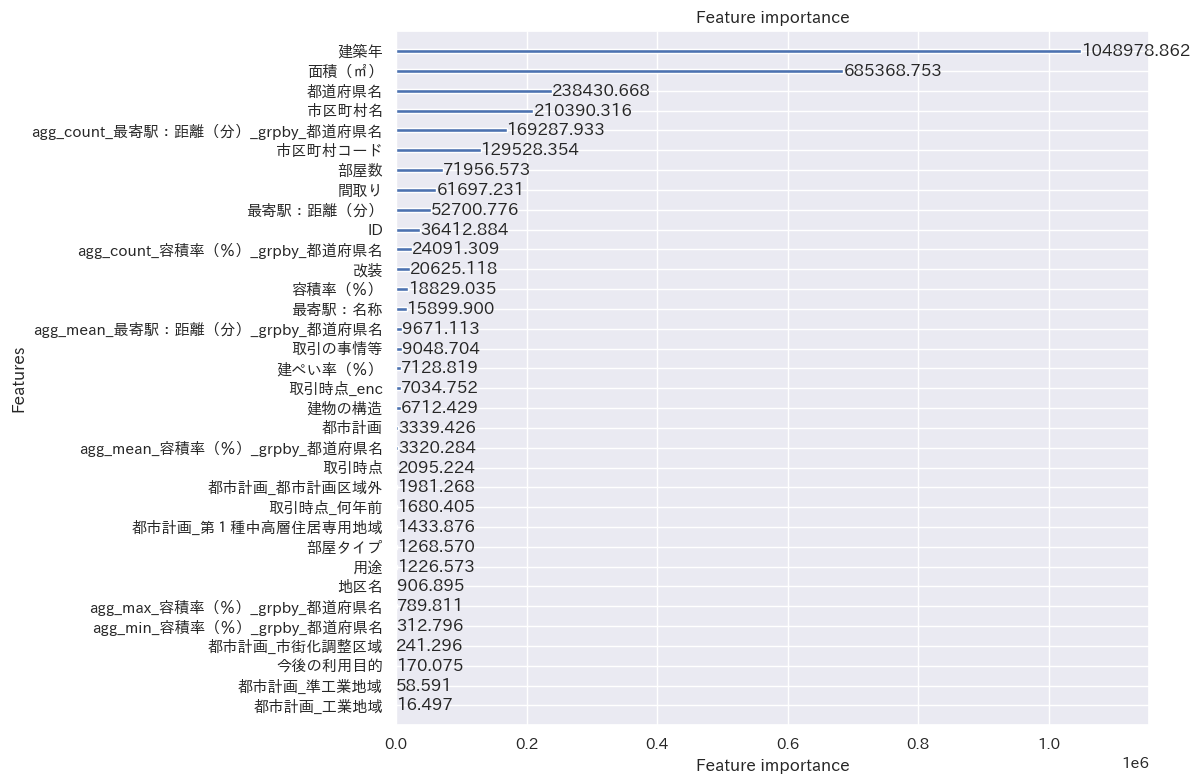

In [37]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

In [38]:
test_df[TARGET] = test_pred

/tmp/ipykernel_110/88504142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [39]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)